In [6]:
!pip install torch
!pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
  Using cached seaborn-0.13.0-py3-none-any.whl.metadata (5.3 kB)
Using cached seaborn-0.13.0-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
# Load helpers and custom dataset class
from __init__ import PricingWizardDataset, base_regression_pipeline, regression_accuracy, threshold_accuracy, load_model, drop_helpers

# Data manipulation 
import pandas as pd
import numpy as np
import time
import math
import os

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# Load Data
data = PricingWizardDataset()

Dataset Loaded: post_preprocessing_without_dummies
	Number of Rows: 283055
	Number of Columns: 22
	Outlier Removal: True
	Train Size: 0.8
	Test Size: 0.2
	Random State: 42


## Load Model

In [3]:
# Current working directory
cwd = os.getcwd()

# model directory
model_dir = os.path.join(cwd, 'models', 'pickled_models')

linear_svr = load_model(f'{model_dir}/prediction_svr_linear.pkl')

Model loaded successfully from /Users/albertobfilho/Repositories/data-mining/pricing_wizards/models/pickled_models/prediction_svr_linear.pkl


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LinearSVR from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [68]:
linear_svr

LinearSVR(C=0.1, dual='auto', epsilon=0.5)

## Linear SVR - Ordinal encoding

In [4]:
# Apply data preparation
print('Applying data preparation...')
data.apply_function(base_regression_pipeline)
print('Done.')

Applying data preparation...
Done.


In [5]:
# Split data
data.stratify_train_test_split(y_column='log_listing_price',
                               val_size=0,
                               return_splits=False)

Dependent variable distribution is equal across all subsets


In [6]:
# StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(drop_helpers(data.X_train))
X_test_scaled = scaler.fit_transform(drop_helpers(data.X_test))

In [7]:
# Evaluate the model using cross-validation and calculates the mean
cv_scores: list = cross_val_score(linear_svr, X_train_scaled, data.y_train, scoring='neg_mean_squared_error', cv=5)
mse_mean_cv_linear: float = -np.mean(cv_scores)

# Train the final model on the entire training set, measuring the training time in seconds
start_time = time.time()
linear_svr.fit(X_train_scaled, data.y_train)
end_time = time.time()

# Calculate training time
training_time_linear = end_time - start_time

# Evaluate the final model on the test set
y_pred_test_base = linear_svr.predict(X_test_scaled)
y_test_base = data.y_test

regression_accuracy(y_pred_test_base, y_test_base)
print("Cross-validation Score:", mse_mean_cv_linear)
print("Training Time:", training_time_linear)

R2 Score: 0.5451406522470428
MSE: 0.438247066338743
MAE 0.5130524938897022
RMSE 0.6620023159617668
Cross-validation Score: 0.4411619876548425
Training Time: 0.8237030506134033


In [8]:
# Calculate permutation importances for the regressor to have a similar metric between the models
feature_importances_values = permutation_importance(linear_svr, X_test_scaled, y_test_base, n_repeats=10, random_state=42).importances_mean
feature_importance = pd.DataFrame({'Feature': drop_helpers(data.X_train).columns, 'Importance': feature_importances_values})
feature_importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
0,brand_name,0.639917
2,subsubsubcategory_name,0.130434
1,condition_name,0.058075


In [9]:
# Feature importance based on regressor coefficients
model_coef = linear_svr.coef_
feature_importance = pd.DataFrame({'Feature': drop_helpers(data.X_train).columns, 'Coef': model_coef})
feature_importance.sort_values(by='Coef', ascending=False)

,Feature,Coef
0,brand_name,0.561385
2,subsubsubcategory_name,0.256809
1,condition_name,0.169080


In [27]:
data.reset_dataset()

## Linear SVR - OHE

#### This model uses all features as dependent variables

In [28]:
# Split data
data.stratify_train_test_split(y_column='log_listing_price',
                               val_size=0,
                               return_splits=False)

Dependent variable distribution is equal across all subsets


In [29]:
# Identify categorical columns
numeric_columns = drop_helpers(data.X_train).select_dtypes(include=['number']).columns
categorical_columns = drop_helpers(data.X_train).select_dtypes(include=['object']).columns

# Create a ColumnTransformer to apply OneHotEncoder to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

# Create a pipeline with preprocessing and Random Forest
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', linear_svr)
])

cv_scores: list = cross_val_score(pipeline, drop_helpers(data.X_train), data.y_train, scoring='neg_mean_squared_error', cv=5)
mse_mean_cv_ohe: float = -np.mean(cv_scores)

# Fit the pipeline on the training data
pipeline.fit(drop_helpers(data.X_train), data.y_train)

# Evaluate the final model on the test set
y_pred_test_ohe = pipeline.predict(drop_helpers(data.X_test))

# Evaluate the model
y_test_ohe = data.y_test
regression_accuracy(y_pred_test_ohe, y_test_ohe)
print("Cross-validation Score:", mse_mean_cv_ohe)

R2 Score: 0.7691087675203649
MSE: 0.22245866942695786
MAE 0.3402639606353207
RMSE 0.4716552442483364
Cross-validation Score: 0.22053327952659027


In [30]:
# Calculate permutation importances for the regressor to have a similar metric between the models
feature_importances_values = permutation_importance(pipeline, drop_helpers(data.X_test), y_test_ohe, n_repeats=10, random_state=42).importances_mean
feature_importance = pd.DataFrame({'Feature': drop_helpers(data.X_train).columns, 'Importance': feature_importances_values})
feature_importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
5,brand_name,0.152610
11,subsubsubcategory_name,0.067010
15,classified_price_normalized,0.065217
2,classified_price,0.065217
12,classified_price_standardized,0.065217
18,log_viewed_count,0.041834
6,condition_name,0.023070
10,subsubcategory_name,0.011940
8,category_name,0.005676
9,subcategory_name,0.002779


### Reducing features

#### This model uses the same features as the ordinal encoding

In [39]:
data.df = data.df[["log_listing_price", "brand_name", "subsubsubcategory_name", "condition_name"]]

In [41]:
# Split data
data.stratify_train_test_split(y_column='log_listing_price',
                               val_size=0,
                               return_splits=False)

Dependent variable distribution is equal across all subsets


In [43]:
# Identify categorical columns
numeric_columns = drop_helpers(data.X_train).select_dtypes(include=['number']).columns
categorical_columns = drop_helpers(data.X_train).select_dtypes(include=['object']).columns

# Create a ColumnTransformer to apply OneHotEncoder to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

# Create a pipeline with preprocessing and Random Forest
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', linear_svr)
])

cv_scores: list = cross_val_score(pipeline, drop_helpers(data.X_train), data.y_train, scoring='neg_mean_squared_error', cv=5)
mse_mean_cv_ohe_reduced: float = -np.mean(cv_scores)

# Fit the pipeline on the training data
pipeline.fit(drop_helpers(data.X_train), data.y_train)

# Evaluate the final model on the test set
y_pred_test_ohe_reduced = pipeline.predict(drop_helpers(data.X_test))

# Evaluate the model
y_test_ohe_reduced = data.y_test
regression_accuracy(y_pred_test_ohe_reduced, y_test_ohe_reduced)
print("Cross-validation Score:", mse_mean_cv_ohe_reduced)

R2 Score: 0.6082709965705753
MSE: 0.37742235572563027
MAE 0.4720048839683886
RMSE 0.6143470971084914
Cross-validation Score: 0.38053037342460977


In [44]:
# Calculate permutation importances for the regressor to have a similar metric between the models
feature_importances_values = permutation_importance(pipeline, drop_helpers(data.X_test), y_test_ohe_reduced, n_repeats=10, random_state=42).importances_mean
feature_importance = pd.DataFrame({'Feature': drop_helpers(data.X_train).columns, 'Importance': feature_importances_values})
feature_importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
0,brand_name,0.729744
1,subsubsubcategory_name,0.387168
2,condition_name,0.093096


In [45]:
data.reset_dataset()

## Visualizations

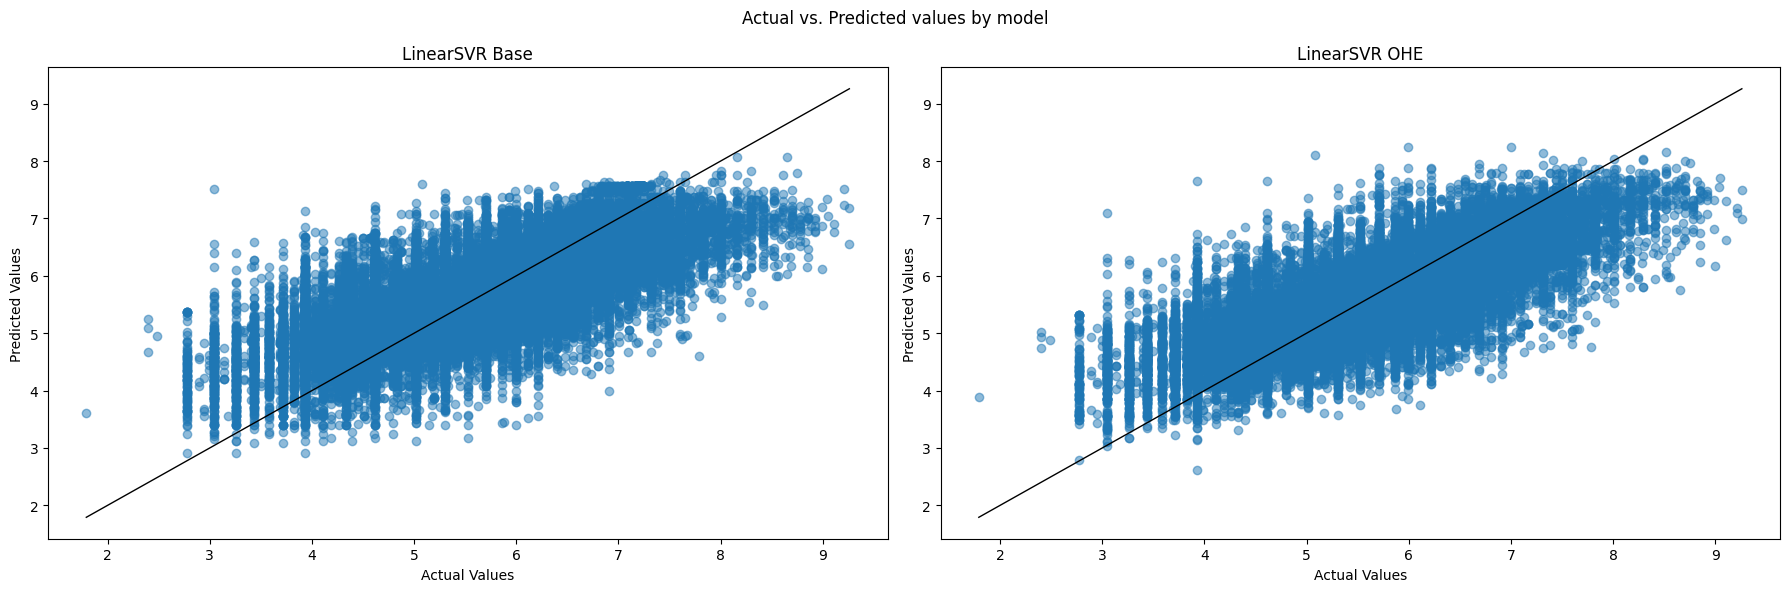

In [69]:
# actual vs predicted
pipelines = [(y_pred_test_base, y_test_base), (y_pred_test_ohe_reduced, y_test_ohe_reduced)]
labels= ["LinearSVR Base", "LinearSVR OHE", "LinearSVR OHE reduced"]

num_models = len(pipelines)
num_cols = 2
num_rows = math.ceil(num_models / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 6*num_rows), tight_layout=True)

for i, (y_pred, y_test) in enumerate(pipelines):
    axs[i].scatter(y_test, y_pred, alpha=0.5)
    axs[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k', lw=1)
    axs[i].set_title(labels[i])
    axs[i].set_xlabel('Actual Values')
    axs[i].set_ylabel('Predicted Values')

plt.suptitle("Actual vs. Predicted values by model")

plt.show(fig)

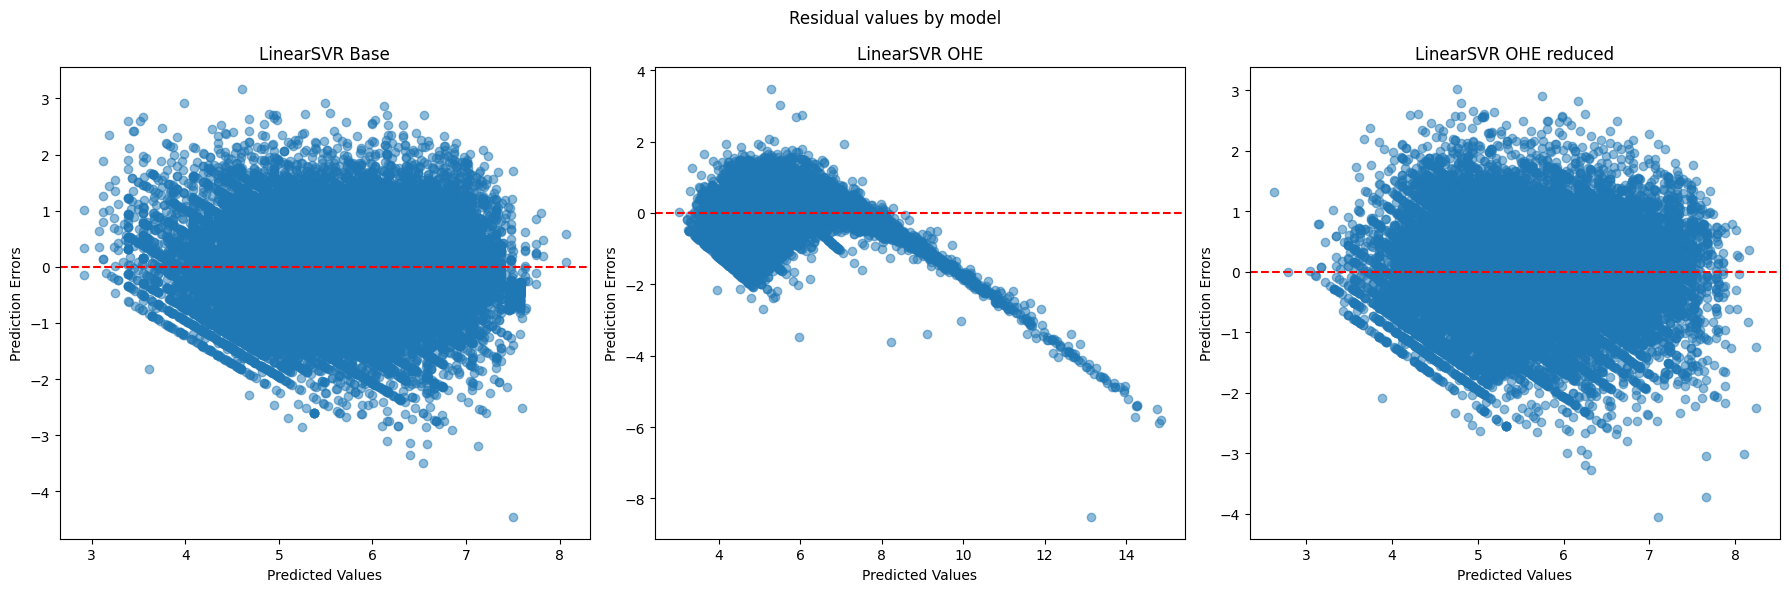

In [35]:
# residuals
pipelines = [(y_pred_test_base, y_test_base), (y_pred_test_ohe, y_test_ohe), (y_pred_test_ohe_reduced, y_test_ohe_reduced)]
labels= ["LinearSVR Base", "LinearSVR OHE", "LinearSVR OHE reduced"]

num_models = len(pipelines)
num_cols = 3
num_rows = math.ceil(num_models / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 6*num_rows), tight_layout=True)

for i, (y_pred, y_test) in enumerate(pipelines):
    # Calculate residuals
    prediction_error = y_test - y_pred

    # Plot the scatter plot on the specific subplot
    axs[i].scatter(y_pred, prediction_error, alpha=0.5)
    axs[i].axhline(y=0, color='r', linestyle='--')
    axs[i].set_title(labels[i])
    axs[i].set_xlabel('Predicted Values')
    axs[i].set_ylabel('Prediction Errors')

plt.suptitle("Residual values by model")

plt.show(fig)

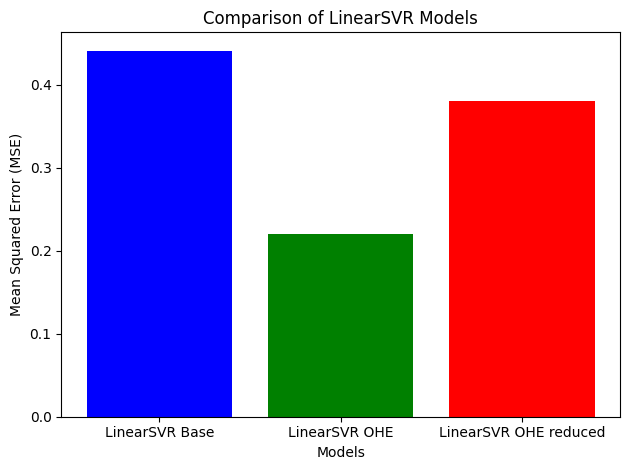

In [66]:
# model evaluation
pipelines = [mse_mean_cv_linear, mse_mean_cv_ohe, mse_mean_cv_ohe_reduced]
labels= ["LinearSVR Base", "LinearSVR OHE", "LinearSVR OHE reduced"]

fig, ax = plt.subplots(tight_layout=True)

# Create a bar plot
plt.bar(labels, pipelines, color=['blue', 'green', 'red'])

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of LinearSVR Models')

# Show the plot
plt.show(fig)